#### Experiment 01: usim as the backing DES framework feasibility

In [1]:
from usim import time, run, Scope, Tracked
class Server:
    def __init__(self, counter, s2):
        self.counter = counter
        self.s2 = s2

    async def get_and_increment(self, request):
        print(f'{time.now} received call with request')
        await (time + 5)
        print(f'{time.now} returning')
        response = self.counter
        self.counter += 1
        await request.set(response)

    def resolve(self):
        return self.s2.get_and_increment, self.s2

    async def rpc(self):
        async with Scope() as client:
            request = Tracked(0)
            api, instance = self.resolve()
            await client.do(api(request))
            response = request.value
            print(f'{time.now} rpc {response=}')

In [2]:
s2 = Server(1000, None)
s1 = Server(0, s2)

async def call_server():
    print(f'{time.now} starting calls')
    await s1.rpc()

run(call_server())

0 starting calls
0 received call with request
5 returning
5 rpc response=1000


#### Experiment 02: Adding some structure to the code for upcoming framework design ideas
* dns resolution of hostnames to server can be simulated by a dictionary lookup to the actual server class
* latency can be simulated by await time
* I also want to simulate the overloading of CPU resources and system behavior of services under load as soon as possible. If some non-linearity of latency can be observed (by logging and plotting), then it indicates this simulation is successful and can be further developed.
  * Probably requires a request queue in the server and cpu resource modelling.

In [3]:
from usim import run, time, Scope, Tracked

class Server:
    def __init__(self):
        self.counter = 0

    async def increment_counter(self, payload):
        await (time + 1)
        self.counter += 1
        response_payload = {
            'counter': self.counter,
            'og_payload': payload
        }
        return Tracked(response_payload)

In [4]:
server_dict = {'a': Server()}

async def rpc(url: str, api: str, payload: dict):
    s = server_dict[url]
    a = getattr(s, api)
    response = await a(payload)
    return response

async def client_logic():
    for _ in range(10):
        print(f'{time.now} - calling rpc')
        response = await rpc('a', 'increment_counter', {1})
        print(f'{time.now} - {response.value}')

run(client_logic(), till=20)

0 - calling rpc
1 - {'counter': 1, 'og_payload': {1}}
1 - calling rpc
2 - {'counter': 2, 'og_payload': {1}}
2 - calling rpc
3 - {'counter': 3, 'og_payload': {1}}
3 - calling rpc
4 - {'counter': 4, 'og_payload': {1}}
4 - calling rpc
5 - {'counter': 5, 'og_payload': {1}}
5 - calling rpc
6 - {'counter': 6, 'og_payload': {1}}
6 - calling rpc
7 - {'counter': 7, 'og_payload': {1}}
7 - calling rpc
8 - {'counter': 8, 'og_payload': {1}}
8 - calling rpc
9 - {'counter': 9, 'og_payload': {1}}
9 - calling rpc
10 - {'counter': 10, 'og_payload': {1}}


#### Experiment 03: adding more layers with the same forumla. See if it scales

In [5]:
from usim import run, time, Tracked
from itertools import cycle

class Logger:
    @staticmethod
    def log(s):
        print(f'{time.now:0>5} - {s}')

class LoadBalancer:
    def __init__(self, server_names):
        self.counter = 0
        self.server_names = cycle(server_names)

    async def compute(self, payload):
        server_name = next(self.server_names)
        Logger.log(f'lb received request forwarding to >> {server_name}')
        await (time + 20)
        return await rpc(server_name, 'compute', payload)

class ComputeServer:
    def __init__(self, name):
        self.name = name
    
    async def compute(self, payload):
        Logger.log(f'{self.name} received {payload}')
        await (time + 200)
        a, b = payload['a'], payload['b']
        response = {
            'result': a + b
        }
        Logger.log(f'{self.name} response {response}')
        return Tracked(response)
    
cs1 = ComputeServer('cs1')
cs2 = ComputeServer('cs2')
cs3 = ComputeServer('cs3')
lb = LoadBalancer(['cs1', 'cs2', 'cs3'])

server_dict = {
    'ComputeService': lb,
    'cs1' : cs1,
    'cs2' : cs2,
    'cs3' : cs3
}

async def rpc(url: str, api: str, payload: dict):
    s = server_dict[url]
    a = getattr(s, api)
    response = await a(payload)
    return response

async def client_logic():
    for _ in range(10):
        Logger.log(f'client calling rpc')
        response = await rpc('ComputeService', 'compute', {'a': 4, 'b': 2})
        Logger.log(f'client response {response.value}')

run(client_logic(), till=1000)

00000 - client calling rpc
00000 - lb received request forwarding to >> cs1
00020 - cs1 received {'a': 4, 'b': 2}
00220 - cs1 response {'result': 6}
00220 - client response {'result': 6}
00220 - client calling rpc
00220 - lb received request forwarding to >> cs2
00240 - cs2 received {'a': 4, 'b': 2}
00440 - cs2 response {'result': 6}
00440 - client response {'result': 6}
00440 - client calling rpc
00440 - lb received request forwarding to >> cs3
00460 - cs3 received {'a': 4, 'b': 2}
00660 - cs3 response {'result': 6}
00660 - client response {'result': 6}
00660 - client calling rpc
00660 - lb received request forwarding to >> cs1
00680 - cs1 received {'a': 4, 'b': 2}
00880 - cs1 response {'result': 6}
00880 - client response {'result': 6}
00880 - client calling rpc
00880 - lb received request forwarding to >> cs2
00900 - cs2 received {'a': 4, 'b': 2}


#### Experiment 04: Simulating Server with compute resources limitation

In [68]:
from usim import run, time, interval, Resources, Tracked, Lock

class Logger:
    @staticmethod
    def log(s):
        print(f'{time.now:0>5} - {s}')

class Server:
    def __init__(self):
        self.counter = 0
        self.lock = Lock()
        self.cpu = Resources(cpu=100)

    async def increment_counter(self, payload):
        async with self.cpu.borrow(cpu=33):
            await (time + 200)
            self.counter += 1
            response_payload = {
                'counter': self.counter,
                'og_payload': payload
            }
        return Tracked(response_payload)

server_dict = {
    'server': Server(),
}

async def rpc(url: str, api: str, payload: dict):
    s = server_dict[url]
    a = getattr(s, api)
    response = await a(payload)
    return response

async def client_logic():
    for _ in range(10):
        Logger.log(f'client calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        Logger.log(f'client response {response.value}, latency: {time.now - start_time}') 

async def run_client(client_id):
    async for now in interval(1000):
        Logger.log(f'{client_id} calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        Logger.log(f'{client_id} response {response.value}, latency: {time.now - start_time}') 


run(*[run_client('a'), run_client('b'), run_client('c'), run_client('d')], till=3000)

01000 - a calling rpc
01000 - b calling rpc
01000 - c calling rpc
01000 - d calling rpc
01200 - a response {'counter': 1, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
01200 - b response {'counter': 2, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
01200 - c response {'counter': 3, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
01400 - d response {'counter': 4, 'og_payload': {'a': 4, 'b': 2}}, latency: 400
02000 - a calling rpc
02000 - b calling rpc
02000 - c calling rpc
02000 - d calling rpc
02200 - a response {'counter': 5, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
02200 - b response {'counter': 6, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
02200 - c response {'counter': 7, 'og_payload': {'a': 4, 'b': 2}}, latency: 200
02400 - d response {'counter': 8, 'og_payload': {'a': 4, 'b': 2}}, latency: 400
03000 - a calling rpc
03000 - b calling rpc
03000 - c calling rpc
03000 - d calling rpc


this models increase of latency when cpu is under high load. There's a major inaccuracy:
1. when cpu is under high load, all processes are likely to suffer, where in this case, the server "rejects" the execution of the new request until cpu resources are released
    *. My solution is to model by "CPU cycles", where we borrow run for N cycles, where each cycles takes X units of cpu resources, and holds it for a short amount of time. This should simulate time-slicing of server threads.

#### Experiment 05: Simulating CPU time slicing

In [ ]:
from usim import run, time, interval, Capacities, Tracked, Lock

class Logger:
    @staticmethod
    def log(s):
        print(f'{time.now:0>5} - {s}')

class Server:
    def __init__(self):
        self.counter = 0
        self.lock = Lock()
        self.cpu = Capacities(cpu=100)
    
    async def increment_counter(self, payload):
        for _ in range(20):
            async with self.cpu.borrow(cpu=33):
                await (time + 10) # simulate cpu time slices in 10 ms granularity
        async with self.lock:
            self.counter += 1
            response_payload = {
                'counter': self.counter,
                'og_payload': payload
            }
            return Tracked(response_payload)

server_dict = {
    'server': Server(),
}

async def rpc(url: str, api: str, payload: dict):
    s = server_dict[url]
    a = getattr(s, api)
    response = await a(payload)
    return response

async def client_logic():
    for _ in range(10):
        Logger.log(f'client calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        Logger.log(f'client response {response.value}, latency: {time.now - start_time}') 

async def run_client(client_id):
    async for now in interval(1000):
        Logger.log(f'{client_id} calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        Logger.log(f'{client_id} response {response.value}, latency: {time.now - start_time}') 


run(*[run_client('a'), run_client('b'), run_client('c'), run_client('d'), run_client('e')], till=3000)

01000 - a calling rpc
01000 - b calling rpc
01000 - c calling rpc
01000 - d calling rpc
01000 - e calling rpc
01310 - d response {'counter': 1, 'og_payload': {'a': 4, 'b': 2}}, latency: 310
01320 - c response {'counter': 2, 'og_payload': {'a': 4, 'b': 2}}, latency: 320
01330 - e response {'counter': 3, 'og_payload': {'a': 4, 'b': 2}}, latency: 330
01330 - a response {'counter': 4, 'og_payload': {'a': 4, 'b': 2}}, latency: 330
01340 - b response {'counter': 5, 'og_payload': {'a': 4, 'b': 2}}, latency: 340
02000 - d calling rpc
02000 - c calling rpc
02000 - e calling rpc
02000 - a calling rpc
02000 - b calling rpc
02310 - d response {'counter': 6, 'og_payload': {'a': 4, 'b': 2}}, latency: 310
02320 - e response {'counter': 7, 'og_payload': {'a': 4, 'b': 2}}, latency: 320
02330 - a response {'counter': 8, 'og_payload': {'a': 4, 'b': 2}}, latency: 330
02330 - c response {'counter': 9, 'og_payload': {'a': 4, 'b': 2}}, latency: 330
02340 - b response {'counter': 10, 'og_payload': {'a': 4, 'b

This minics reality better. 

#### Experiment 06: client-side latency and concurrent clients plot

In [83]:
from usim import run, time, interval, delay, Capacities, Tracked, Lock, Scope
from sortedcontainers import SortedList
from collections import defaultdict
import random

class Logger:
    @staticmethod
    def log(s):
        # print(f'{time.now:0>5} - {s}')
        pass

class Metrics:
    m = defaultdict(SortedList)
    @staticmethod
    def add_metric(timestamp, metric_name, metric_value):
        Metrics.m[metric_name].add((timestamp, metric_value))

class Server:
    def __init__(self):
        self.counter = 0
        self.lock = Lock()
        self.cpu = Capacities(cpu=100)
    
    async def increment_counter(self, payload):
        for _ in range(20):
            async with self.cpu.borrow(cpu=random.randint(20, 40)):
                await (time + 10) # simulate cpu time slices in 10 ms granularity
        async with self.lock:
            self.counter += 1
            response_payload = {
                'counter': self.counter,
                'og_payload': payload
            }
            return Tracked(response_payload)

server_dict = {
    'server': Server(),
}

async def rpc(url: str, api: str, payload: dict):
    s = server_dict[url]
    a = getattr(s, api)
    response = await a(payload)
    return response

async def client_logic():
    for _ in range(10):
        Logger.log(f'client calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        Logger.log(f'client response {response.value}, latency: {time.now - start_time}') 

async def run_client(client_id):
    # async for now in interval(1000):
    while True:
        Logger.log(f'{client_id} calling rpc')
        start_time = time.now
        response = await rpc('server', 'increment_counter', {'a': 4, 'b': 2})
        latency = time.now - start_time
        Metrics.add_metric(time.now, 'client_latency', latency)
        Logger.log(f'{client_id} response {response.value}, latency: {latency}') 

# add a new client every second
async def schedule_clients(num_clients):
    async with Scope() as scope:
        for i in range(num_clients):
            scope.do(run_client(f'client_{i}'), after=250*i) # must use after, if I write `async for.. delay` here the loop hangs

run(schedule_clients(20), till=50000)

In [96]:
import pandas as pd
from matplotlib import pyplot as plt
client_latency_metric = Metrics.m['client_latency']
x, y = zip(*client_latency_metric)
df = pd.DataFrame(dict(timestamp=list(x), latency=list(y)))
df['p90'] = df['latency'].rolling(window=10).apply(lambda x: x.quantile(0.9, interpolation='nearest'))
df['concurrent_clients'] = df['timestamp'].apply(lambda x: min(x//250, 20)).astype(int)

In [99]:
df.describe()

,timestamp,latency,p90,concurrent_clients
count,744.000000,744.000000,735.000000,744.000000
mean,25434.771505,911.559140,1441.632653,19.166667
std,14238.625484,2759.026539,3542.121249,3.164689
min,200.000000,200.000000,270.000000,0.000000
25%,13245.000000,400.000000,540.000000,20.000000
50%,25435.000000,440.000000,670.000000,20.000000
75%,37732.500000,562.500000,940.000000,20.000000
max,49900.000000,38040.000000,24780.000000,20.000000


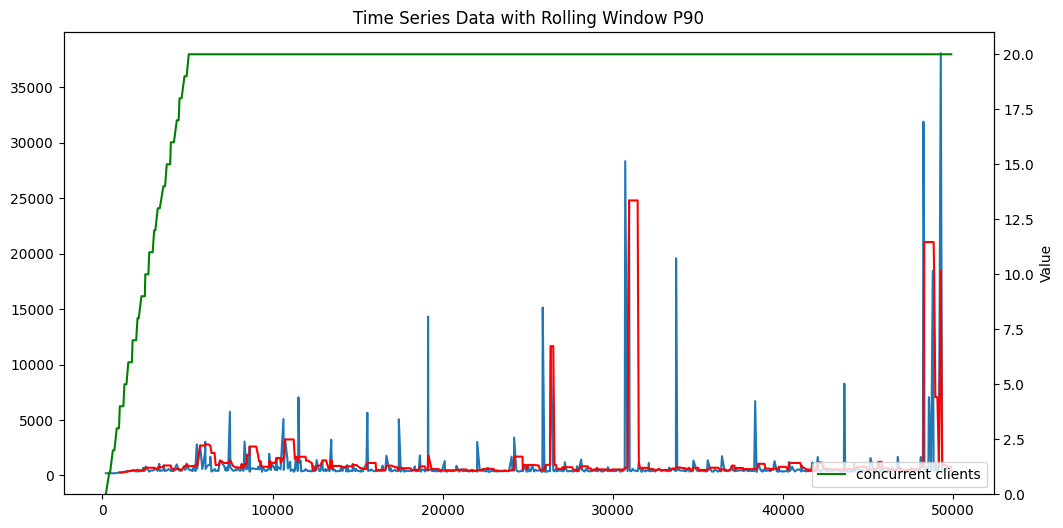

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['latency'], label='Original Data')
plt.plot(df['timestamp'], df['p90'], label='P90, rolling window', color='red')
ax2 = plt.gca().twinx()  # gca() gets the current axis
ax2.plot(df['timestamp'], df['concurrent_clients'], label='concurrent clients', color='green')
plt.title('Time Series Data with Rolling Window P90')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(bottom=0)
plt.legend()
plt.show()

* Don't fully get why average latency is around 900ms where some outliers go up to 38000ms